In [39]:
import pandas as pd
import numpy as np

In [40]:
# Read data from addHealth Wave I dataset
data = pd.read_csv('addhealth_pds.csv', low_memory=False)

print("There are {0} rows and {1} columns".format(data.shape[0], data.shape[1]))

There are 6504 rows and 2829 columns


In [41]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

from collections import OrderedDict

In [42]:
class AnalysisBase(object):
    """
    Base class for initializing data, settings and cleaning data

    Parameters
    ----------
    dataset : string
        File name of the dataset.
    usecols : list
        List of column names that are of interests.
    debug : boolean
        Print extra data for debug purpose.
    input_var : dict
        Key-Value pairs used as input variables.
        Key, description of column.
        Value, column code used in original dataset.
    output_var : dict
        Key-Value pairs used as output variables.
        Key, description of column.
        Value, column code used in original dataset.
    """
    def __init__(self, dataset, usecols=None, debug=False, input_var=None, output_var=None):
        
        if usecols:
            self.data = pd.read_csv(dataset, usecols=['H1TO35', 'H1WP8', 'H1PF1', 'H1PF23',
                                                      'AID', 'H1CO1', 'H1CO3', 'H1CO6'])
        else:
            self.data = pd.read_csv(dataset)
        self.debug = debug
        self.input_var = input_var
        self.output_var = output_var

        # Construct cleaned dataset, with with columns that are of interests and readable column labels 
        self.cleaned_data = self.construct_dataset()

    def loving_parents(self, row):
        """
        Used to categorize parents showing love.
        
        In the original dataset, there are 2 columns, 
        "Most of the time, your mother is warm and loving toward you.", 
        "Most of the time, your father is warm and loving toward you.". 
        Their mappings are as followed:
        1 => strongly agree
        2 => agree
        3 => neither agree nor disagree
        4 => disagree
        5 => strongly disagree
        6 => refused
        7 => legitimate skip (no resident MOM)
        8 => don't know
        
        Scores and categories are listed below:
            - Scores for both mother and father that are less than and equal to 2
                are categorized as "agree to feel love from parent".
            - Scores for both mother and father that are 3
                are categorized as "neutral to feel love from parent".
            - Scores for both mother and father that are between 4 and 5
                are categorized as "neutral to feel love from parent".
                
        Returns
        -------
        string: string
            Label used to describe how adolescents feel if they have "loving_parents"

        """
        if (row["mother_is_warm_loving"] <= 2) & (row["father_is_warm_loving"] <= 2):
            return "1-AGREE"
        elif (row["mother_is_warm_loving"] == 3) & (row["father_is_warm_loving"] == 3):
            return "2-NEUTRAL"
        elif (row["mother_is_warm_loving"] >= 4) & (row["mother_is_warm_loving"] <= 5) &\
                (row["father_is_warm_loving"] >= 4) & (row["father_is_warm_loving"] <= 5):
            return "3-DISAGREE"
        
    def construct_dataset(self):
        """
        Construct dataset. Change column codes to readable labels.
        Use data that have responds: "yes", "no" to "Have you ever had sexual intercourse?".
        Categorize loving parent and cocaine usage.
        
        Returns
        -------
        cleaned_data: Pandas Dataframe
            Cleaned dataset with readable labels

        """
        if self.debug:
            print("Before cleaning the data...\nNumber of {} rows".format(self.data.shape[0]))
            print("Number of {} columns\n".format(self.data.shape[1]))
            
        # Drop NAN data
        self.data.fillna(np.nan)
        if self.debug:
            print("After dropping NAN...\nNumber of {} rows".format(self.data.shape[0]))
            print("Number of {} columns\n".format(self.data.shape[1]))
            
        # AID is the id (index) of the dataset
        self.cleaned_data = self.data[["AID"]].copy()
        # Update to use readable column labels
        for k, v in self.output_var.items():
            self.cleaned_data[k] = self.data[v].copy()
            # Make sure data are numeric
            self.cleaned_data[k] = pd.to_numeric(self.cleaned_data[k])
        for k, v in self.input_var.items():
            self.cleaned_data[k] = self.data[v].copy()
            # Make sure data are numeric
            self.cleaned_data[k] = pd.to_numeric(self.cleaned_data[k])

        # Use records that have responses: "yes" or "no" to having sexual experience
        self.cleaned_data = self.cleaned_data[(self.cleaned_data.had_sexual_intercourse <= 1)]
        self.cleaned_data["loving_parents"] = self.cleaned_data.apply(lambda row: self.loving_parents(row), axis=1)
        
        # Categorize Cocaine usage, 1: at least once, 0: Never
        # There is no 0 in the original dataest column H1TO35
        self.cleaned_data["USED_COCAINE"] = pd.cut(self.cleaned_data.use_cocaine_freq, [0, 995, 999], labels=[1, 0])
        self.cleaned_data["USED_COCAINE"] = pd.to_numeric(self.cleaned_data["USED_COCAINE"])
        self.cleaned_data = self.cleaned_data.dropna()
        
        if self.debug:
            print("After cleaning...\nNumber of {} rows".format(self.cleaned_data.shape[0]))
            print("Number of {} columns\n".format(self.cleaned_data.shape[1]))
    
        return self.cleaned_data

In [43]:
input_var = {"no_of_evening_meal_with_1_parent_past_7_days": "H1WP8",
             "mother_is_warm_loving": "H1PF1",
             "father_is_warm_loving": "H1PF23"}

output_var = {"had_sexual_intercourse": "H1CO1",
              "used_birth_control_first_time": "H1CO3",
              "used_birth_control_most_recently": "H1CO6",
              "use_cocaine_freq": "H1TO35"}


base_test = AnalysisBase("addhealth_pds.csv",
                         usecols=['H1TO35', 'H1WP8', 'H1PF1', 'H1PF23', 'AID', 'H1CO1', 'H1CO3', 'H1CO6'],
                         debug=True,
                         input_var=input_var,
                         output_var=output_var)

Before cleaning the data...
Number of 6504 rows
Number of 8 columns

After dropping NAN...
Number of 6504 rows
Number of 8 columns

After cleaning...
Number of 3465 rows
Number of 10 columns



In [44]:
print(base_test.data.head())
print(base_test.cleaned_data.head())

        AID  H1WP8  H1PF1  H1PF23  H1CO1  H1CO3  H1CO6  H1TO35
0  57100270      7      1       2      1      1      1     997
1  57101310      7      1       1      1      0      0     997
2  57103171      7      1       1      0      7      7     997
3  57103869      7      2       7      1      1      1     998
4  57104553      7      2       7      1      0      0     997
        AID  used_birth_control_most_recently  had_sexual_intercourse  \
0  57100270                                 1                       1   
1  57101310                                 0                       1   
2  57103171                                 7                       0   
5  57104649                                 7                       0   
6  57104676                                 7                       0   

   use_cocaine_freq  used_birth_control_first_time  father_is_warm_loving  \
0               997                              1                      2   
1               997          

In [45]:
class AdolescentsAnalysis(AnalysisBase):
    """
    Analysis of how adolescent feels about their parents and their risky behaviors.

    Parameters
    ----------
    dataset : string
        File name of the dataset.
    usecols : list
        List of column names that are of interests.
    debug : boolean
        Print extra data for debug purpose.
    input_var : dict
        Key-Value pairs used as input variables.
        Key, description of column.
        Value, column code used in original dataset.
    output_var : dict
        Key-Value pairs used as output variables.
        Key, description of column.
        Value, column code used in original dataset.

    See also
    --------
    AnalysisBase
        Base class for initializing data, settings and cleaning data
    """
    
    def __init__(self, dataset, usecols=None, debug=False, input_var=None, output_var=None):
        super().__init__(dataset, usecols=usecols, debug=debug, input_var=input_var, output_var=output_var)
        
        self.adolescent_feelings = OrderedDict([
                                    ("1-AGREE", "\nAdolescents agree both parents are loving"),
                                    ("2-NEUTRAL", "\nAdolescents neither agree nor disagree both parents are loving"),
                                    ("3-DISAGREE", "\nAdolescents disagree both parents are loving")])

    def print_group_stat(self, x_vars, y, debug=False):
        """
        Calculate percentages of each category x_vars against y from the dataset.

        Parameters
        ----------
        x_vars : Dict
            Key, categories of how adolescents feel about having loving parents, e.g.
                1-AGREE, 2-NEUTRAL, 3-DISAGREE.
            Value, Description of the key.
        y : String
            Column Label of dataset.
        debug : Boolean
            Print extra data for debug purpose.

        Returns
        -------
        None

        """
        if not debug:
            debug = self.debug
        # Loop through each x category, 1-AGREE, 2-NEUTRAL, 3-DISAGREE
        for k, v in x_vars.items():
            print(v, "(0: No, 1: Yes)\n")
            subset = self.cleaned_data.copy()
            subset = subset[subset["loving_parents"] == k]
            
            # use data that has "yes" or "no" to y variable
            subset = subset[(subset[y] <= 1)]
            print(subset.shape) if debug else False
                
            # find the freq of "yes" and "no" of y variable of each category
            print(subset[y].value_counts(normalize=True).sort_index())
            print()
        
    def graph_bar_chart(self, dataset, x_independent_var, y_dependent_var, x_label, y_label, title, filename=None):
        """
        Draw a categorical bar chart.
        Save the graph optionally if filename is supplied.

        Parameters
        ----------
        dataset : Pandas DataFrame
            Cleaned dataset.
        x_independent_var : String
            Column Label for x variable.
        y_dependent_var : String
            Column Label for y variable.
        x_label : String
            Description for x axis.
        y_label : String
            Description for y axis.
        title : String
            Title of the graph.
        filename : String
            File name used for saving the plot.
            
        Returns
        -------
        None
        """
        g = sns.factorplot(y=y_dependent_var, x=x_independent_var, data=dataset, kind="bar", ci=None, size=7, aspect=1)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title(title)
        if filename:
            g.savefig(filename, dpi=300)
            
    def adolescents_feel_vs_sex_in_the_past(self, filename=None, debug=False):
        """
        This function is to explore the relative frequencies related to the following question:
            How the adolescent feel about his/her parent 
                vs 
            if he/she engaged in sexual intercourse (H1CO1)?
        A bar chart is also created to help for visualization.

        Parameters
        ----------
        filename : String
            Filename for saving graph to disk.
        debug : Boolean
            Print extra data for debug purpose.
            
        Returns
        -------
        None
        """
        if not debug:
            debug = self.debug
        x_independent_var = "loving_parents"
        y_dependent_var = "had_sexual_intercourse"
        
        x_vars = OrderedDict(((k, v + ", and had sex in the past")
                              for k, v in self.adolescent_feelings.items()))
        self.print_group_stat(x_vars, y_dependent_var, debug)
        
        subset = self.cleaned_data.copy()
        subset[x_independent_var] = subset[x_independent_var].astype("category")
        # consider data that has "yes" or "no" to column "had_sexual_intercourse"
        subset = subset[(subset[y_dependent_var] <= 1)]
        
        # Graph a bar chart of the relationship
        x_label = "Adolescents feel love from both parents"
        y_label = "Adolescents had sexual intercourse"
        title = "Adolescent's Relationship with Parents\nvs\nHad Sexual Intercourse Experience"
        self.graph_bar_chart(subset, x_independent_var, y_dependent_var,
                             x_label, y_label, title, filename)

    def adolescents_feel_vs_use_birth_control_the_first_time(self, filename=None, debug=False):
        """
        This function is to explore the relative frequencies related to the following question:
            How the adolescent feel about his/her parent 
                vs 
            if he/she used any method of birth control the first time he/she had sexual intercourse (H1CO3)?
        A bar chart is also created to help for visualization.

        Parameters
        ----------
        filename : String
            Filename for saving graph to disk.
        debug : Boolean
            Print extra data for debug purpose.
            
        Returns
        -------
        None
        """
        if not debug:
            debug = self.debug
        x_independent_var = "loving_parents"
        y_dependent_var = "used_birth_control_first_time"
        
        x_vars = OrderedDict(((k, v + ", and used birth control during first time sex")
                              for k, v in self.adolescent_feelings.items()))
        self.print_group_stat(x_vars, y_dependent_var, debug)
        
        subset = self.cleaned_data.copy()
        subset[x_independent_var] = subset[x_independent_var].astype("category")
        # consider data that has "yes" or "no" to column "used_birth_control_first_time"
        subset = subset[(subset[y_dependent_var] <= 1)]
        
        # Graph a bar chart of the relationship
        x_label = "Adolescents feel love from both parents"
        y_label = "Adolescents used birth control during first time sex"
        title = "Adolescent's Relationship with Parents\nvs\nBirth Control during First Time Sex"
        self.graph_bar_chart(subset, x_independent_var, y_dependent_var,
                             x_label, y_label, title, filename)
        
    def adolescents_feel_vs_use_birth_control_recently(self, filename=None, debug=False):
        """
        This function is to explore the relative frequencies related to the following question:
            How the adolescent feel about his/her parent 
                vs 
            if he/she used any method of birth control during recent sex (H1CO6)?
        A bar chart is also created to help for visualization.

        Parameters
        ----------
        filename : String
            Filename for saving graph to disk.
        debug : Boolean
            Print extra data for debug purpose.
            
        Returns
        -------
        None
        """
        if not debug:
            debug = self.debug
        x_independent_var = "loving_parents"
        y_dependent_var = "used_birth_control_most_recently"
        
        x_vars = OrderedDict(((k, v + ", and used birth control during recent sex")
                              for k, v in self.adolescent_feelings.items()))
        self.print_group_stat(x_vars, y_dependent_var, debug)
        
        subset = self.cleaned_data.copy()
        subset[x_independent_var] = subset[x_independent_var].astype("category")
        # consider data that has "yes" or "no" to column "used_birth_control_most_recently"
        subset = subset[(subset[y_dependent_var] <= 1)]
        
        # Graph a bar chart of the relationship
        x_label = "Adolescents feel love from both parents"
        y_label = "Adolescents used birth control during recent sex"
        title = "Adolescent's Relationship with Parents\nvs\nBirth Control During Recent Sex"
        self.graph_bar_chart(subset, x_independent_var, y_dependent_var,
                             x_label, y_label, title, filename)
        
    # How Adolescents feel vs cocaine usage
    def adolescents_feel_vs_cocaine_usage(self, filename=None, debug=False):
        """
        This function is to explore the relative frequencies related to the following question:
            How the adolescent feel about his/her parent 
                vs 
            if he/she used cocaine at least once before (H1TO35)?
        A bar chart is also created to help for visualization.

        Parameters
        ----------
        filename : String
            Filename for saving graph to disk.
        debug : Boolean
            Print extra data for debug purpose.
            
        Returns
        -------
        None
        """
        
        """ Adolescents feel love and warmth from both parents: 1-AGREE, 2-NEUTRAL, 3-DISAGREE
            vs
            Adolescents used cocaine at least once
        """
        if not debug:
            debug = self.debug
        x_independent_var = "loving_parents"
        y_dependent_var = "USED_COCAINE"
        
        x_vars = OrderedDict(((k, v + ", and used cocaine in the past")
                              for k, v in self.adolescent_feelings.items()))
        
        # Print the freq stat
        self.print_group_stat(x_vars, y_dependent_var, debug)
        
        # Make a subset
        subset = self.cleaned_data.copy()
        subset[x_independent_var] = subset[x_independent_var].astype("category")
        
        # Graph a bar chart of the relationship
        x_label = "Adolescents feel love from both parents"
        y_label = "Adolescents used cocaine in the past"
        title = "Adolescent's Relationship with Parents\nvs\nUsed Cocaine in the Past"
        self.graph_bar_chart(subset, x_independent_var, y_dependent_var,
                             x_label, y_label, title, filename)
        

In [46]:
import warnings
warnings.filterwarnings('ignore')

In [47]:
input_var = {"no_of_evening_meal_with_1_parent_past_7_days": "H1WP8",
             "mother_is_warm_loving": "H1PF1",
             "father_is_warm_loving": "H1PF23"}

output_var = {"had_sexual_intercourse": "H1CO1",
              "used_birth_control_first_time": "H1CO3",
              "used_birth_control_most_recently": "H1CO6",
              "use_cocaine_freq": "H1TO35"}

adolescents_analysis = AdolescentsAnalysis("addhealth_pds.csv",
                                           usecols=['H1TO35', 'H1WP8', 'H1PF1', 'H1PF23', 'AID',
                                                    'H1CO1', 'H1CO3', 'H1CO6'],
                                           debug=False,
                                           input_var=input_var,
                                           output_var=output_var)


Adolescents agree both parents are loving, and had sex in the past (0: No, 1: Yes)

0    0.701943
1    0.298057
Name: had_sexual_intercourse, dtype: float64


Adolescents neither agree nor disagree both parents are loving, and had sex in the past (0: No, 1: Yes)

0    0.430556
1    0.569444
Name: had_sexual_intercourse, dtype: float64


Adolescents disagree both parents are loving, and had sex in the past (0: No, 1: Yes)

0    0.458333
1    0.541667
Name: had_sexual_intercourse, dtype: float64



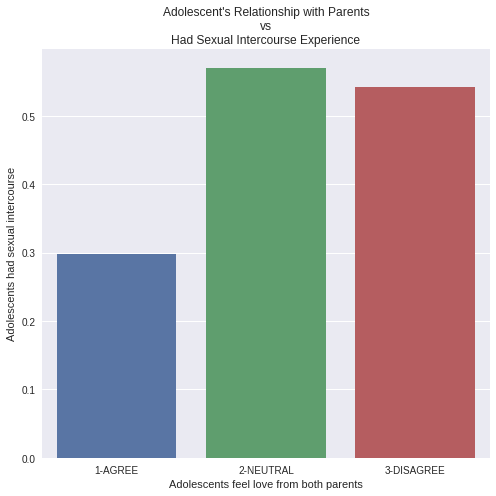

In [48]:
adolescents_analysis.adolescents_feel_vs_sex_in_the_past()


Adolescents agree both parents are loving, and used birth control during first time sex (0: No, 1: Yes)

0    0.291919
1    0.708081
Name: used_birth_control_first_time, dtype: float64


Adolescents neither agree nor disagree both parents are loving, and used birth control during first time sex (0: No, 1: Yes)

0    0.536585
1    0.463415
Name: used_birth_control_first_time, dtype: float64


Adolescents disagree both parents are loving, and used birth control during first time sex (0: No, 1: Yes)

0    0.384615
1    0.615385
Name: used_birth_control_first_time, dtype: float64



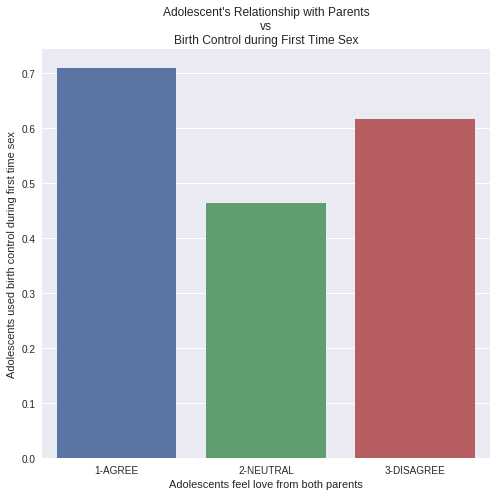

In [49]:
adolescents_analysis.adolescents_feel_vs_use_birth_control_the_first_time()


Adolescents agree both parents are loving, and used birth control during recent sex (0: No, 1: Yes)

0    0.291539
1    0.708461
Name: used_birth_control_most_recently, dtype: float64


Adolescents neither agree nor disagree both parents are loving, and used birth control during recent sex (0: No, 1: Yes)

0    0.390244
1    0.609756
Name: used_birth_control_most_recently, dtype: float64


Adolescents disagree both parents are loving, and used birth control during recent sex (0: No, 1: Yes)

0    0.384615
1    0.615385
Name: used_birth_control_most_recently, dtype: float64



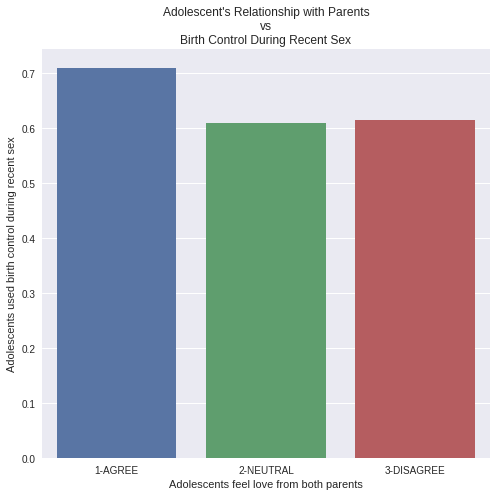

In [50]:
adolescents_analysis.adolescents_feel_vs_use_birth_control_recently()


Adolescents agree both parents are loving, and used cocaine in the past (0: No, 1: Yes)

0    0.984454
1    0.015546
Name: USED_COCAINE, dtype: float64


Adolescents neither agree nor disagree both parents are loving, and used cocaine in the past (0: No, 1: Yes)

0    0.958333
1    0.041667
Name: USED_COCAINE, dtype: float64


Adolescents disagree both parents are loving, and used cocaine in the past (0: No, 1: Yes)

0    0.916667
1    0.083333
Name: USED_COCAINE, dtype: float64



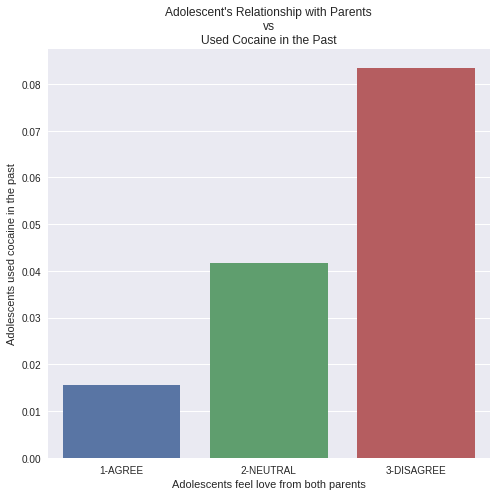

In [51]:
adolescents_analysis.adolescents_feel_vs_cocaine_usage()